
# Assignment 4 
In this assignment you will be working with a character based LSTM language model, which you will turn into a text classifier for sentiment analysis using **Attention**. For that, you will need to develop the Attention mechanism that aggregates the hidden output vectors that you get per character into a single vector, which you will use as an input for a final linear classifier.


Submitted:

*   Hadar Pur
*   Rotem Feinblat

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from random import sample

In [ ]:
!git clone https://github.com/kfirbar/course-ml-data.git

Cloning into 'course-ml-data'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 5), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


The data that you will be working with is SST-2, which is a collection of reviews, each is classified into 0/1 reflecting the overall sentiment of the author (0 = negative, 1 = positive). In the next piece of code, we load the data and create a dictionary (named Vocab) that assigns a unique ID per character, similar to what have done in DL Notebook 12. Finally, each one of *train* and *dev* is a list of tuples, with the first item being the text encoded as character indices, and the second item is the label (0, 1).

In [ ]:
# We will work only with texts of size < 50 characters
MAX_SEQ_LEN = 50

class Vocab:
    def __init__(self):
        self.char2id = {}
        self.id2char = {}
        self.n_chars = 1
        
    def index_text(self, text):
      indexes = [self.index_char(c) for c in text]
      return indexes
    
    def index_char(self, c):
        if c not in self.char2id:
            self.char2id[c] = self.n_chars
            self.id2char[self.n_chars] = c
            self.n_chars += 1
        return self.char2id[c]
            
            
def load_data(data, vocab):
  data_sequences = []
  for text in data.iterrows():
    if len(text[1]["sentence"]) <= MAX_SEQ_LEN:
      indexes = vocab.index_text(text[1]["sentence"])
      data_sequences.append((indexes, text[1]["label"]))
  return data_sequences

vocab = Vocab()
train = load_data(pd.read_csv('/content/course-ml-data/SST2_train.tsv', sep='\t'), vocab)
dev = load_data(pd.read_csv('/content/course-ml-data/SST2_dev.tsv', sep='\t'), vocab)
print(f'Train size {len(train)}, Dev size {len(dev)}, vocab size {vocab.n_chars}')

Train size 40625, Dev size 119, vocab size 63


# Task 1
The following RNN architectures takes a single sentence as an input (formatted as a 1D tensor of character ids), and returns a distribution over the labels. In our case the number of labels is 2 (negative, positive). 

I basically copied the same architecture from Notebook 12, where each input character gets an output vector from the LSTM module, which are used to precdict the next character in line. However, here, we are not really interested in predicting the next character, but in aggregating all those output vectors into a single "context" vector, which will be sent to a Linear layer for the final classification step.

Therefore, you are requested to add the relevant code for aggregating the output vectors using the **additive attention** approach, following presentation *DL 14*. Note that some of what you need to add should be parameters, which you need to define under the __init__ function.


In [ ]:
#@title
class SeqModel(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size):
    super(SeqModel, self).__init__()
    ##input size , hidden size - the size of the embbeding that we create 
    self.embedding = torch.nn.Embedding(input_size, embedding_size)
    ##the embedding create the weigths 
    ##lstm create the vector h
    self.rnn = torch.nn.LSTM(embedding_size, hidden_size)
    
    # TODO: add the relevant initialization code for the Attention mechanism
    ##need to define (say, new_linear in our case)
    self.new_linear=torch.nn.Linear(hidden_size, hidden_size)
    ##new trainable v vector,We define v as a tensor of the size hidden_size.a 
    self.v = torch.nn.Parameter(torch.randn(hidden_size)) 
    self.out = torch.nn.Linear(hidden_size, output_size)

  def forward(self, single_sentence):
    # single_sentence is a 1D tensor containing indices of the sentence characters
    embedded = self.embedding(single_sentence)
    embedded = embedded.view(len(single_sentence), 1, -1) ##like reshape create tensor with 3 things. the first is the size of the sentence ,1 the second is the batch, 
    out, hidden = self.rnn(embedded) ## the out is h, and the hidden is h and c
    # TODO: calculate the context vector, which is a weighted average of the out vectors, with weights learned automatically
    out = out.squeeze()
    o = torch.tanh(self.new_linear(out))

    alpha = torch.nn.functional.softmax(torch.matmul(o, self.v)) 
    #Once we have the probabilities, need to multiply each output vector by its weight, and then sum them up element wise, to get a single vector.
    context = torch.matmul(alpha, out)
    return self.out(context).view(1, -1)



# Task 2
Once completed, you are now requested to write some code for training the model using the following configuration. Make sure to print the training loss every 100 sentences so you can follow. Train your code for 4 epochs, and use cuda + GPU.

In [ ]:
model = SeqModel(vocab.n_chars, 64, 300, 2).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train_loss_calculation(epochs,batch_size):
  train_loss_array=[]
  test_loss_array=[]

  # training loop
  for e in range(epochs):  
    running_loss = 0.0
    train_loss = 0.0
    for i, data in enumerate(train, 0):
      # get the inputs
      inputs, labels = data # -- For CPU
        
      inputs = torch.LongTensor(inputs).cuda() # -- For GPU
      labels = torch.LongTensor([labels]).cuda() # -- For GPU

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      train_loss += loss.item()
      if (i+1) % batch_size == 0:    
        print('[%d, %5d/%d] Loss: %.3f' %(e + 1, i + 1,len(train), running_loss / batch_size))
        running_loss = 0.0

    # calculate train loss for epoch
    train_loss_calc = train_loss / len(train)
    train_loss_array.append(train_loss_calc)

  return train_loss_array

In [ ]:
# setup
batch_size = 100
epochs = 4
epoch_array = list(range(1,epochs+1))

# train 
train_loss_array= train_loss_calculation(epochs, batch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100/40625] Loss: 0.725
[1,   200/40625] Loss: 0.724
[1,   300/40625] Loss: 0.705
[1,   400/40625] Loss: 0.701
[1,   500/40625] Loss: 0.690
[1,   600/40625] Loss: 0.684
[1,   700/40625] Loss: 0.693
[1,   800/40625] Loss: 0.776
[1,   900/40625] Loss: 0.726
[1,  1000/40625] Loss: 0.665
[1,  1100/40625] Loss: 0.728
[1,  1200/40625] Loss: 0.711
[1,  1300/40625] Loss: 0.709
[1,  1400/40625] Loss: 0.715
[1,  1500/40625] Loss: 0.710
[1,  1600/40625] Loss: 0.706
[1,  1700/40625] Loss: 0.687
[1,  1800/40625] Loss: 0.719
[1,  1900/40625] Loss: 0.682
[1,  2000/40625] Loss: 0.686
[1,  2100/40625] Loss: 0.706
[1,  2200/40625] Loss: 0.728
[1,  2300/40625] Loss: 0.711
[1,  2400/40625] Loss: 0.712
[1,  2500/40625] Loss: 0.676
[1,  2600/40625] Loss: 0.720
[1,  2700/40625] Loss: 0.679
[1,  2800/40625] Loss: 0.677
[1,  2900/40625] Loss: 0.679
[1,  3000/40625] Loss: 0.654
[1,  3100/40625] Loss: 0.744
[1,  3200/40625] Loss: 0.714
[1,  3300/40625] Loss: 0.700
[1,  3400/40625] Loss: 0.698
[1,  3500/4062

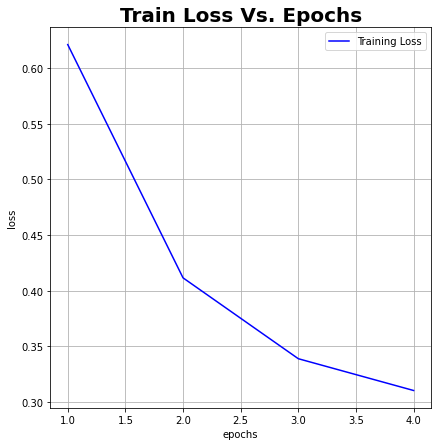

In [ ]:
##loss graph
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 2)
plt.plot(epoch_array, train_loss_array, 'b', label='Training Loss')
plt.title('Train Loss Vs. Epochs', fontsize = 20, weight='bold')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

# Task 3
Write some code for evaluating your model on the dev set. Since the data is almost balanced (there are 52 positives in the dev set), let's print accuracy (i.e., the number of correctly classified instances).

In [ ]:
# Your evalutation code goes here
correct = 0
total = 0
with torch.no_grad():
  for sequence in dev:
    inputs,label=sequence
    inputs = torch.LongTensor(inputs).cuda()  
    label = torch.LongTensor([label]).cuda()
    output = model(inputs).cuda()
    _, predicted = torch.max(output, 1)
    total += 1
    correct += (predicted == label).sum().item()


acc = 100.0 * correct / total
print(f'Accuracy: {acc} %')

Accuracy: 85.71428571428571 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
